In [1]:
import glob
import pandas as pd
import numpy as np
import awkward as ak

import utils.tools as tools1
import utils.plotting as plotting

from collections import OrderedDict, defaultdict
import uproot

import mplhep as cms
import matplotlib.pyplot as plt

cms.style.use("CMS")
plt.rcParams["figure.figsize"] = (7,7)

In [2]:
# input data definition
# put "default" objects first
# i.e. those that should be used to obtain fixed rate

#nComp = 3

#l1Labels = ['L1', 'L1_noJEC', 'L1_noJECnoPUSnoPUM']
#branchTypes = ['unp', 'emu', 'emu'] # unp or emu

#sigPaths  = ["zmu24I_noJEC/", "zmu24I_noJEC/", "zmu24I_noJEC_noPUS_noPUM/"]
#bkgPaths  = ["zb24I_noJEC/", "zb24I_noJEC/", "zb24I_noJEC_noPUS_noPUM/"]

nComp = 3

l1Labels = ['Default', 'BaselineZS', 'ConservativeZS']
branchTypes = ['emu', 'emu', 'emu'] # unp or emu


In [3]:
rootDir = "/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/ddharmen/JECs2025/"
zmumu="zmumu/RAW_RECO/"
zerobias="zerobias/RAW/"

finalpath="0003/"

sigPaths  = ["default/Muon0/jetMET24I/250228_195726/", "baseline/Muon0/jetMET24I/250228_195617/", "conservative/Muon0/jetMET24I/250228_195652/"]
bkgPaths  = ["default/ZeroBias/jetMET24I/250301_183717/", "baseline/ZeroBias/jetMET24I/250301_183552/", "conservative/ZeroBias/jetMET24I/250301_183634/"]
fileName = "nano*.root"


inputFormat = 'nano'     # nanoAOD
#inputFormat = 'hdf5'     # pandas dataframes

sigName = "zmu"
bkgName = "zb"

writeDir = "./data/"

# fileName = "/eos/home-d/ddharmen/JEC/CMSSW_14_1_4_patch1/src/JETMET/zerobias_perf_raw_test/default/nano*.root"
fileName = "nano_30*.root"
# fileName = "nano_99.root"

sigFiles = [glob.glob(rootDir + zmumu + path + finalpath + fileName) for path in sigPaths]
bkgFiles = [glob.glob(rootDir + zerobias + path + finalpath + fileName) for path in bkgPaths]

# len(sigFiles)
len(bkgFiles)

3

In [4]:
if len(l1Labels) != nComp or len(branchTypes) != nComp or len(sigFiles) != nComp or len(bkgFiles) != nComp:
       raise TypeError("Number of inputs datasets is not consistent")


awkSigFiles = [writeDir + "/" + sigName + label + ".parq" for label in l1Labels]
awkBkgFiles = [writeDir + "/" + bkgName + label + ".parq" for label in l1Labels]

sig_hdf5s = [writeDir + "/" + sigName + label + ".hdf5" for label in l1Labels]
bkg_hdf5s = [writeDir + "/" + bkgName + label + ".hdf5" for label in l1Labels]

# L1 thresholds (GeV)
l1JetThresholds = [30, 120, 180]
l1METThresholds = [50, 90]
# arrays containing our signal and background data
# for the different sets of input files
sigs = []
bkgs = []

sig_dfs = []
bkg_dfs = []

In [5]:
# print("Signal files:", sigFiles)
# print("Background files:", bkgFiles)


In [6]:
if inputFormat == 'nano':
    
    for sigFile, awkSigFile, branchType in  zip(sigFiles, awkSigFiles, branchTypes):
        sigs.append(tools1.getArrays(sigFile, tools1.getBranches(['Jet'], branchType=='emu', False), len(sigFile), awkSigFile))
                       
    for bkgFile, awkBkgFile, branchType in zip(bkgFiles, awkBkgFiles, branchTypes):
        bkgs.append(tools1.getArrays(bkgFile, tools1.getBranches(['Jet'], branchType=='emu', False), len(bkgFile), awkBkgFile))


if inputFormat == 'parquet':

    for awkSigFile in awkSigFiles:
        sigs.append(ak.from_parquet(awkSigFile))

    for awkBkgFile in awkBkgFiles:
        bkgs.append(ak.from_parquet(awkBkgFile))

In [7]:
if inputFormat in ['nano', 'parquet']:

    for sig, sig_hdf5, l1Label in zip(sigs, sig_hdf5s, l1Labels):
        # get the puppiMETs
        puppiMET, puppiMETNoMu = tools1.getPUPPIMET(sig)
        puppiJET, puppiJETNoMu = tools1.getPUPPIJET(sig)
        # get the l1METs
        # l1MET_df = pd.DataFrame(ak.to_list(ak.flatten(tools1.getSum(sig, 'methf')['EtSum_pt'])), columns=[l1Label])
        l1MET_df = pd.DataFrame(ak.to_list(tools1.getL1EmulJet1(sig)), columns=[l1Label])
        puppiMET_df = pd.DataFrame(ak.to_list(puppiJET['recoJet_leadingPt']), columns=['PuppiMET'])
        puppiMETNoMu_df = pd.DataFrame(ak.to_list(puppiJETNoMu['recoJet_leadingPt']), columns=['PuppiMETNoMu'])
        # save to dataframe
        pd.concat([l1MET_df, puppiMET_df, puppiMETNoMu_df], axis=1).to_hdf(sig_hdf5, l1Label, mode='w')
        
    for bkg, bkg_hdf5, l1Label in zip(bkgs, bkg_hdf5s, l1Labels):
        
        l1MET_df = pd.DataFrame(ak.to_list(tools1.getL1EmulJet1(bkg)), columns=[l1Label])
        l1MET_df.to_hdf(bkg_hdf5, l1Label, mode='w')
        
    
for sig_hdf5, l1Label in zip(sig_hdf5s, l1Labels):
    sig_dfs.append(pd.read_hdf(sig_hdf5, l1Label))
    
for bkg_hdf5, l1Label in zip(bkg_hdf5s, l1Labels):
    bkg_dfs.append(pd.read_hdf(bkg_hdf5, l1Label))

/tmp/ipykernel_4125/2593579416.py:13: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  pd.concat([l1MET_df, puppiMET_df, puppiMETNoMu_df], axis=1).to_hdf(sig_hdf5, l1Label, mode='w')
/tmp/ipykernel_4125/2593579416.py:13: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  pd.concat([l1MET_df, puppiMET_df, puppiMETNoMu_df], axis=1).to_hdf(sig_hdf5, l1Label, mode='w')
/tmp/ipykernel_4125/2593579416.py:13: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  pd.concat([l1MET_df, puppiMET_df, puppiMETNoMu_df], axis=1).to_hdf(sig_hdf5, l1Label, mode='w')
/tmp/ipykernel_4125/2593579416.py:18: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  l1MET_df.to_hdf(bkg_hdf5

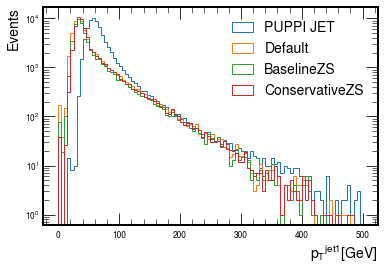

In [8]:
# plot the MET distributions
plt.hist(sig_dfs[0]['PuppiMET'], bins = 100, range = [0,500], histtype = 'step', log = True, label = "PUPPI JET")
# plt.hist(sig_dfs[0]['PuppiMETNoMu'], bins = 100, range = [0,2000], histtype = 'step',  label = "PUPPI JET NoMu")

for sig_df, l1Label in zip(sig_dfs, l1Labels):
    plt.hist(sig_df[l1Label], bins = 100, range = [0,500], histtype = 'step', label = l1Label)


plt.legend(fontsize=14)
plt.xlabel(r'p${_T}^{jet1}$[GeV]', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.yscale('log')
plt.savefig("plots/JET_jet1.pdf", format="pdf")
plt.show()


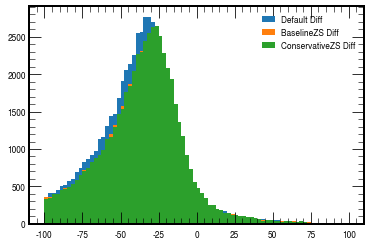

In [9]:
# plot the MET resolution
for sig_df, l1Label in zip(sig_dfs, l1Labels):
    plt.hist((sig_df[l1Label] - sig_df['PuppiMETNoMu']), bins = 80, range = [-100,100], label = l1Label + " Diff")

plt.legend()

In [10]:
# make fixed rate MET efficiencies

# rate plots must be in bins of GeV
ptRange = [0,500]
bins = ptRange[1]

l1JETRates = []
l1JETThresholds = [30, 120, 180]

l1JETThresholdsArr = [l1JETThresholds]

# get rate hist for "default" objects
rateScale = 40000000*(2452/3564)/len(bkg_dfs[0])
rateHist = plt.hist(bkg_dfs[0], bins=bins, range=ptRange, histtype = 'step', label=l1Labels[0], cumulative=-1, log=True, weights=np.full(len(bkg_dfs[0]), rateScale))

for l1JETThreshold in l1JETThresholds:
    # get rates for the default thresholds
    l1JETRate = rateHist[0][l1JETThreshold]
    l1JETRates.append(l1JETRate)

for i in range(1, nComp):
    # get thresholds for the fixed rates
    rateScale = 40000000*(2452/3564)/len(bkg_dfs[i])
    rateHist = plt.hist(bkg_dfs[i], bins=bins, range=ptRange, histtype = 'step', label=l1Labels[i], cumulative=-1, log=True, weights=np.full(len(bkg_dfs[i]), rateScale))
    thresholds = []
    for l1JETThreshold in l1JETThresholds:
        # get threshold for this rate
        thresholds.append(plotting.getThreshForRate(rateHist[0], bins, l1JETRates[l1JETThresholds.index(l1JETThreshold)]))
    l1JETThresholdsArr.append(thresholds)

plt.legend(fontsize=14)
plt.xlabel(r'L1 p${_T}^{jet1}$[GeV]', fontsize=14)
plt.ylabel('Rate [Hz]')
plt.yscale('log')
plt.tight_layout()
plt.savefig("plots/JET_jet1_rates.pdf", format="pdf")
plt.clf()
plt.show()

<Figure size 432x288 with 0 Axes>

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:246: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


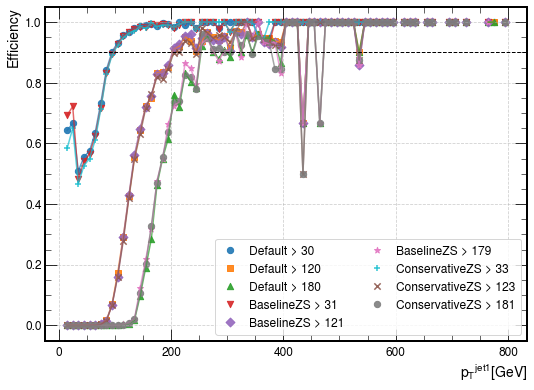

In [15]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.style.use(cms.style.ROOT)

# Define markers and colors
markers = cycle(['o', 's', '^', 'v', 'D', '*', '+', 'x'])
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                '#e377c2', '#17becf', '#8c564b', '#7f7f7f', '#bcbd22'])

plt.figure(figsize=(8, 6))  # Increase figure size

for sig_df, l1Label, l1JETThresholds in zip(sig_dfs, l1Labels, l1JETThresholdsArr):
    for l1JETThreshold in l1JETThresholds:
        eff_data, xvals, err = plotting.efficiency(sig_df[l1Label], sig_df['PuppiMET'], l1JETThreshold,10, 800)
        
        color = next(colors)
        marker = next(markers)
        
        # Scatter plot for exact points
        plt.scatter(xvals, eff_data, 
                    label=f"{l1Label} > {l1JETThreshold}", 
                    marker=marker, 
                    color=color, 
                    s=40,  # Increase marker size
                    alpha=0.9)  # Transparency for better readability

        # Line plot to connect points
        plt.plot(xvals, eff_data, 
                 linestyle='-',  # Solid line
                 color=color, 
                 alpha=0.7,  # Slight transparency
                 linewidth=1.5)  # Moderate line width

# Reference line at 95% efficiency
plt.axhline(0.90, linestyle='--', color='black', linewidth=1)

# Formatting
plt.legend(fontsize=12, loc='lower right', ncol=2, frameon=True)  # Adjust legend
plt.xlabel(r'p${_T}^{jet1}$[GeV]', fontsize=14)
plt.ylabel('Efficiency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)  # Add a light grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the figure
plt.savefig("plots/Jet1_eff.pdf", format="pdf", dpi=300)  # Higher DPI for clarity
plt.show()  # Show instead of clearing immediately
